In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
#loading Dataset
df = pd.read_csv("decision_curve_data.csv")

**Question 1:** What is the intervention associated with the readmission model?

Answer: We are looking at the case of predicting hospital readmission. Although not all readmission may be preventable, we can try to minimize it by **not discharging** the patients with a high risk of readmission and keeping them under observation longer. Patients with a low risk can be safely discharged.

**Question 2:** In figure 1 from 'a simple, step-by-step guide to interpreting decision curve analysis', the extremes of the x-axis are 'I'm worried about disease' and 'I'm worried about biopsy'. What do the extremes of this scale represent for the readmission case?

Answer: The extremes of this scale represent how much we care about false negative predictions (worried about disease) versus false positive predictions (worried about biopsy). For the readmission case, the left end of the scale represent physicians that are worried about readmissions and want to prevent them at all cost. The right end of the scale represents physicians that are worried about keeping patients in the hospital for longer than clinically necessary. 

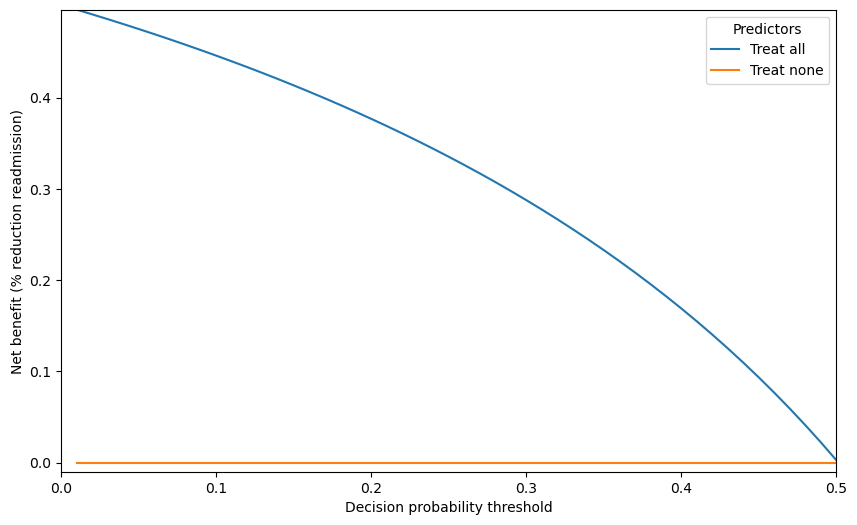

In [24]:
def decision_curve(data, probabilities, y, labels, xlim=[0,1]):
    y = data.loc[:,y]
    event_rate = np.mean(y)
    N = data.shape[0]

    # make nb table
    nb = pd.DataFrame(np.arange(0.01,1,0.01),columns=['threshold'])
    nb['treat_all'] = event_rate - (1-event_rate)*nb.threshold/(1-nb.threshold)
    nb['treat_none'] = 0

    # Make plot
    ymax = np.max(np.max(nb.loc[:,nb.columns!='threshold']))
    plt.figure(figsize=(10,6))
    plt.plot(nb.threshold, nb.treat_all)
    plt.plot(nb.threshold, nb.treat_none)
    plt.ylim(bottom=-0.01,top=ymax)
    plt.xlim(left=xlim[0],right=xlim[1])
    plt.legend(title='Predictors', labels=['Treat all','Treat none']+labels)
    plt.xlabel('Decision probability threshold')
    plt.ylabel('Net benefit (reduction readmission)')

    return plt

# Generate decision curve
probabilities = ['logit_pred','dtree_pred','rm_pred']
labels = ['Logistic regression','Decision tree', 'Random Forest']
y = 'readmitted'
plt = decision_curve(df, probabilities, y, labels, xlim=[0,0.5])
plt.show()

**Question 3:** What do the 'treat all' and 'treat none' strategies signify in the readmission case? 

Answer: A readmission prediction model aims to lower the number of readmissions. To prevent readmissions, patients with a high risk of readmission may be kept in the hospital longer. Treating none refers to the scenario where there is no intervention based on prediction model outcomes. It is 'business as usual'. A better description might be 'treating no one differently from standard care'. Standard care in the readmission case is discharging all patients according to the original scheme. Treating all refers to the scenario where we treat all patients as if they will be readmitted. We will correctly help those patients that would actually have been readmitted, but there will be a lot of false positive patients too, that will be retained at the hospital for much longer than needed.   

**Question 4:** Fill in the formula for net benefit.

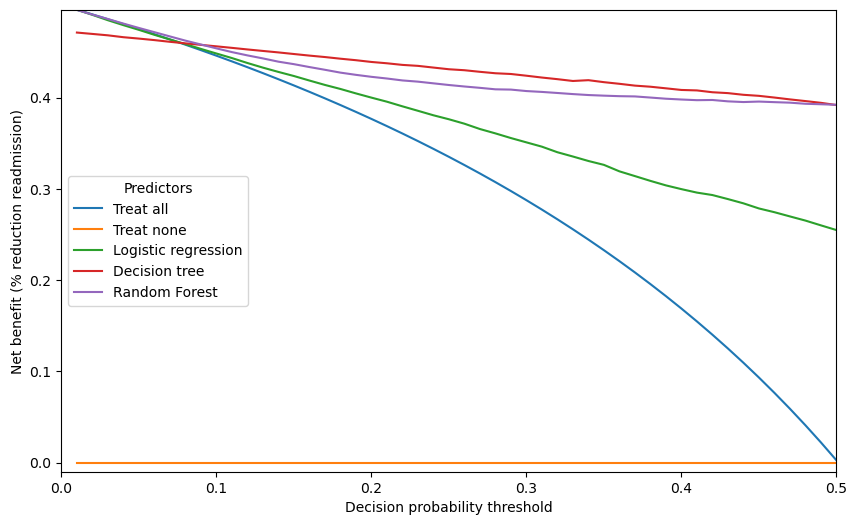

In [26]:
def decision_curve(data, probabilities, y, labels, xlim=[0,1]):
    y = data.loc[:,y]
    event_rate = np.mean(y)
    N = data.shape[0]

    # make nb table
    nb = pd.DataFrame(np.arange(0.01,1,0.01),columns=['threshold'])
    nb['treat_all'] = event_rate - (1-event_rate)*nb.threshold/(1-nb.threshold)
    nb['treat_none'] = 0

    # cycling through each predictor and calculating net benefit
    for m in probabilities:
        nb[m] = 0
        p = data.loc[:,m]
        for ind,t in enumerate(nb.threshold):
            tp = np.sum(y.loc[p>=t]==True)
            fp = np.sum(y.loc[p>=t]==False)
            if np.sum(p>=t)==0:
                tp=fp=0
            nb.iloc[ind,nb.columns.get_indexer([m])] = tp/N-(fp/N)*(t/(1-t))

    # Make plot
    ymax = np.max(np.max(nb.loc[:,nb.columns!='threshold']))
    plt.figure(figsize=(10,6))
    plt.plot(nb.threshold, nb.treat_all)
    plt.plot(nb.threshold, nb.treat_none)
    for m in probabilities:
        plt.plot(nb.threshold, nb.loc[:,m])
    plt.ylim(bottom=-0.01,top=ymax)
    plt.xlim(left=xlim[0],right=xlim[1])
    plt.legend(title='Predictors', labels=['Treat all','Treat none']+labels)
    plt.xlabel('Decision probability threshold')
    plt.ylabel('Net benefit (reduction readmission)')

    return plt

# Generate decision curve
probabilities = ['logit_pred','dtree_pred','rm_pred']
labels = ['Logistic regression','Decision tree', 'Random Forest']
y = 'readmitted'
plt = decision_curve(df, probabilities, y, labels, xlim=[0,0.5])
plt.show()

**Question 5:** What does net benefit represent? 

Answer: At a risk threshold of 10%, all models have approximately the same net benefit of 0.5. This means that at this risk threshold and adhering to the prediction model outcomes, there is a net reduction of 50% percentage points in patients that would have been readmitted.

**Question 6:** Discuss the plot. Which model do you prefer based on NB approach? Why?

Answer: The logistic regression model and the random forest model lie on top of the treat all and treat none strategies. They provide better overall strategies (higher net benefit) across all ranges of decision thresholds. The decision tree model lies on top of all models for most of the decision probability range. However, below 0.1 the net benefit is lower than for the treat all strategy, meaning that if you are very risk averse, this is not a good model to apply. 